# Stuff for Machine Learning

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

from tensorflow.keras import datasets, layers, models, optimizers

from ImagingSoftware.ImageProcessing import *
from ImagingSoftware.ImageClassifier import *

import logging
logging.basicConfig(level=logging.INFO)

In [10]:
def make_training_dataset(exposure_time, n_tweezers, n_loops, testing_fraction=0.1):
    path = f"Data/06:23:23/imaging exposure time = {exposure_time}ms/"
    crops = []
    labels = []
    positions = None
    for file in os.listdir(path):
        if file.endswith('.mat'):
            data = loadmat(path + file)
            if positions is None:
                processor = GreenImageProcessor(data['stack'], n_tweezers, n_loops)
                positions = processor.tweezer_positions
            else:
                processor = GreenImageProcessor(data['stack'], n_tweezers, n_loops, tweezer_positions=positions)
            file_crops, file_labels = processor.make_dataset()
            crops.append(file_crops)
            labels.append(file_labels)
    crops = np.concatenate(crops, axis=0)
    labels = np.concatenate(labels, axis=0)
    testing_indices = np.random.choice(len(crops), int(len(crops) * testing_fraction), replace=False)
    np.savez_compressed(path + f"{exposure_time}ms training dataset",
                        training_crops=np.delete(crops, testing_indices, axis=0),
                        training_labels=np.delete(labels, testing_indices, axis=0),
                        testing_crops=crops[testing_indices],
                        testing_labels=labels[testing_indices],
                        positions=positions)
    return

def make_fidelity_dataset(exposure_time, n_tweezers, n_loops):
    path = f"Data/06:23:23/imaging exposure time = {exposure_time}ms/"
    crops = []
    positions = None
    for file in os.listdir(path):
        if file.endswith('.mat'):
            data = loadmat(path + file)
            if positions is None:
                processor = GreenImageProcessor(data['stack'], n_tweezers, n_loops)
                positions = processor.tweezer_positions
            else:
                processor = GreenImageProcessor(data['stack'], n_tweezers, n_loops, tweezer_positions=positions)
            crops.append(processor.crop_tweezer(3))
    crops = np.concatenate(crops, axis=0)
    np.savez_compressed(path + f"{exposure_time}ms fidelity analysis dataset", crops=crops)
    return crops


def load_training_dataset(exposure_time):
    path = f"Data/06:23:23/imaging exposure time = {exposure_time}ms/"
    return np.load(path + f"{exposure_time}ms training dataset.npz", allow_pickle=True)

def load_fidelity_dataset(exposure_time):
    path = f"Data/06:23:23/imaging exposure time = {exposure_time}ms/"
    return np.load(path + f"{exposure_time}ms fidelity analysis dataset.npz", allow_pickle=True)

In [11]:
def architecture_0(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.Conv2D(n_filters, filter_size, strides=1, activation='relu'))
    network.add(layers.MaxPooling2D(pool_size=(2, 2)))
    network.add(layers.Flatten())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

def architecture_1(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu'))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu'))
    network.add(layers.Flatten())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network   

def architecture_2(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu'))
    network.add(layers.MaxPooling2D(pool_size=(2, 2)))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu'))
    network.add(layers.Flatten())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

def architecture_3(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu'))
    network.add(layers.MaxPooling2D(pool_size=(2, 2)))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu'))
    network.add(layers.Flatten())
    network.add(layers.Dense(9, activation='sigmoid'))
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

# Make a File of Training/Testing Data


In [14]:
exposure_time = 25
n_tweezers = 100
n_loops = 20
path = f"Data/06:23:23/imaging exposure time = {exposure_time}ms/"
#make_training_dataset(exposure_time, n_tweezers, n_loops)
#make_fidelity_dataset(exposure_time, n_tweezers, n_loops)


# Load a File of Testing/Training Data

In [16]:
training_data = load_training_dataset(exposure_time)
fidelity_data = load_fidelity_dataset(exposure_time)
print(training_data['training_labels'].shape)
print(training_data['testing_labels'].shape)
positions = training_data['positions']

(1975432, 2)
(219492, 2)


# Test Model Fidelities

In [19]:
classifier = ImageClassifier(filename=path + 'model2.h5')
classifier.evaluate(training_data['testing_crops'], training_data['testing_labels'])

6860/6860 [==============================] - 10s 1ms/step - loss: 0.0081 - binary_accuracy: 0.9983


80938/80938 [==============================] - 98s 1ms/step


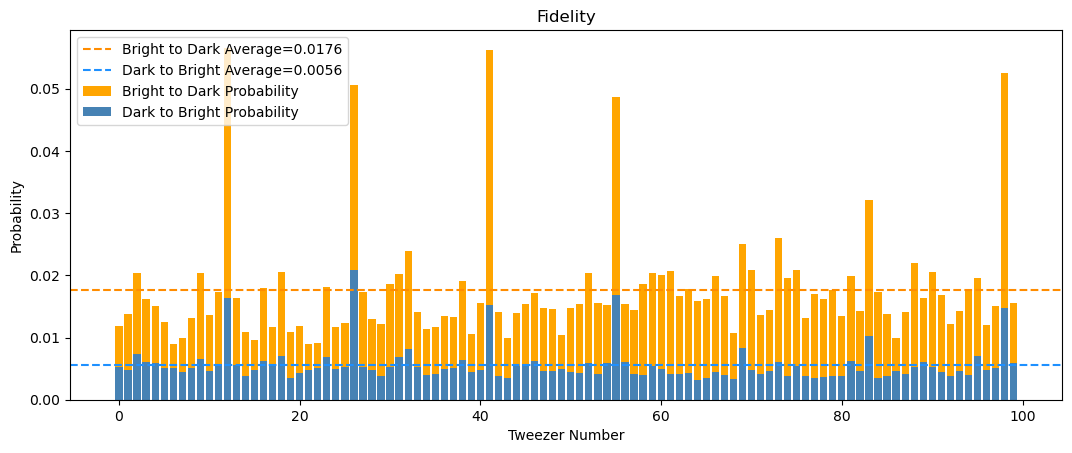

(array([0.00527317, 0.00471244, 0.00731404, 0.00606721, 0.00594393,
        0.00502858, 0.00514035, 0.00452806, 0.00512284, 0.0064759 ,
        0.00456505, 0.00575177, 0.01641614, 0.00563294, 0.0038842 ,
        0.0047656 , 0.00626035, 0.00571021, 0.00708346, 0.00342857,
        0.00437198, 0.00473564, 0.00510145, 0.00690335, 0.00486007,
        0.00530504, 0.02083672, 0.00525559, 0.00472207, 0.00376238,
        0.00524341, 0.00692409, 0.00807393, 0.00530928, 0.0039895 ,
        0.00418473, 0.00489122, 0.00517349, 0.00638276, 0.00442059,
        0.00483497, 0.01517888, 0.00382226, 0.00354001, 0.00546161,
        0.00567801, 0.00619611, 0.00466942, 0.00459713, 0.00496251,
        0.00451456, 0.00424076, 0.00596898, 0.00419925, 0.00590356,
        0.01689661, 0.0060396 , 0.00408183, 0.00400996, 0.00536102,
        0.00495868, 0.00408163, 0.00406542, 0.00432498, 0.00319285,
        0.00356465, 0.00448991, 0.00400335, 0.00326193, 0.00835073,
        0.00485618, 0.00414796, 0.00454024, 0.00

In [20]:
classifier.fidelity_analysis(fidelity_data['crops'], n_tweezers, n_loops, plot=True)

# Thresholding Stuff

In [24]:
import sys, os, glob
import warnings
import numpy as np
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt

import scipy as sp
from scipy.optimize import curve_fit
warnings.filterwarnings("ignore")
import pandas as pd
from analysis_thompsonlab_amo import *
#Setting the default style of our plots.

plt.style.use('seaborn-muted')
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.autolayout'] = True
matplotlib.rcParams['figure.figsize'] = (5.5, 4)
matplotlib.rcParams['legend.fontsize'] = 'small'
matplotlib.rcParams['legend.title_fontsize'] = 'small'
matplotlib.rcParams['legend.loc'] = 'best'
plotOptions={'marker':'o', 'linestyle':'-', 'linewidth':0.5, 'alpha':0.8, 'elinewidth':2}

In [25]:
relpath = f"Data/06:23:23/imaging exposure time = {exposure_time}ms/"
prefix = "/Users/jackmango/Desktop/QUIRP - Work/Princeton"
data = dataset(relpath, prefix)

In [26]:
%matplotlib inline
data.addDir(relpath, prefix)
includefn = lambda f: True # if f.params['imagingDetuning0_MHz'] == -0.55 else False
dhist = measurement(data, ['all'], includefn=includefn)

nTweezers = 100
histy = weighted_histogram_556(dhist.files, nTweezers=100, rAtom=2, exclude1st = True, nLoops = 20)

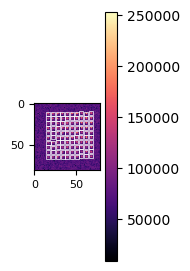

In [27]:
positions = histy.findPositions(plot=True)

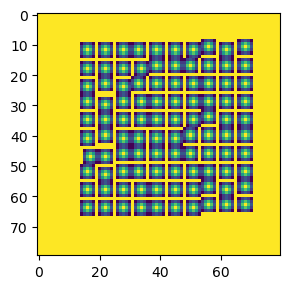

R2 = 0.987 at site 75


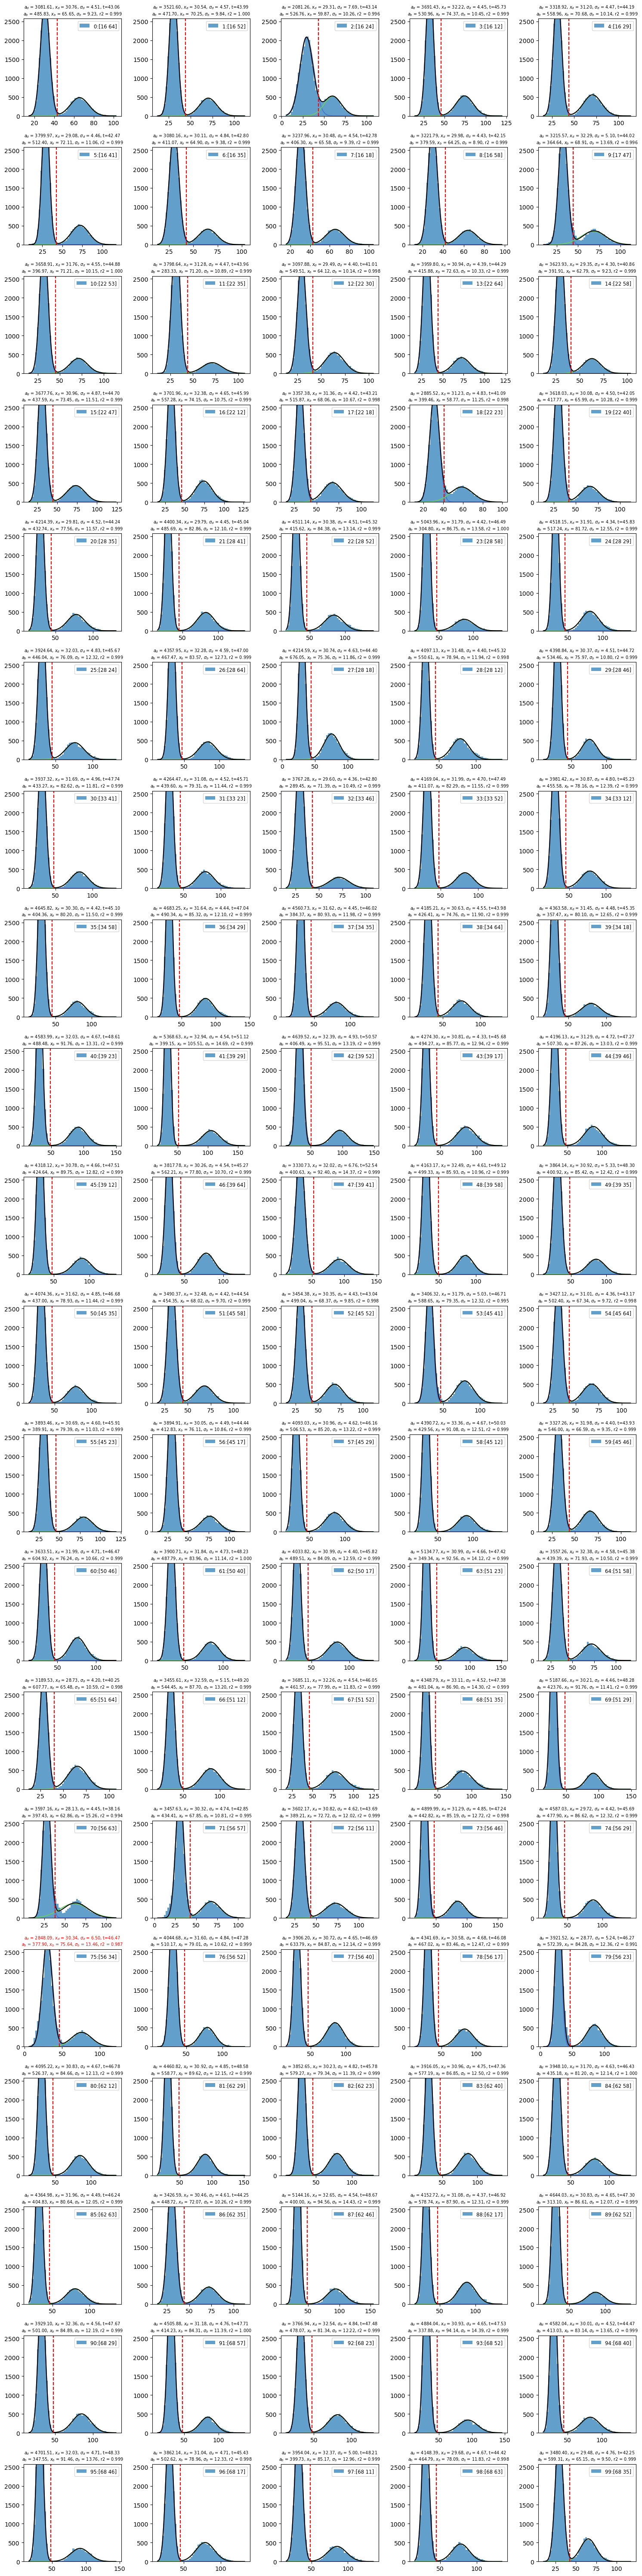

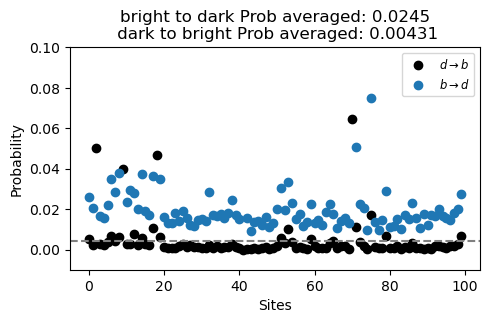

In [28]:
histy.calculateWeights(bgExcludeRegion = [[10,5],[73,75]])

fitParams = [5 for _ in range(nTweezers)]
histy.applyWeights(weights=True, fitParams=fitParams)

histy.thresholds[41]= 10000

probs = histy.fidelityAnalysis(plot=True)